In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [1]:
!pip install diffusers torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.6 MB/s eta 0:00:00a 0:00:01


In [2]:
device = 'cuda:1'

In [3]:
import torch
import torch.nn as nn
from diffusers import StableDiffusionPipeline

# EEG Projection Layer
class EEGProjectionLayer(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EEGProjectionLayer, self).__init__()
        self.projection = nn.Linear(input_dim, latent_dim)

    def forward(self, eeg_embeddings):
        return self.projection(eeg_embeddings)

# EEG-enhanced U-Net, using cross-attention for EEG embeddings
class EEGEnhancedUNet(nn.Module):
    def __init__(self, unet, eeg_projection_layer):
        super(EEGEnhancedUNet, self).__init__()
        self.unet = unet
        self.eeg_projection_layer = eeg_projection_layer

    def forward(self, latents, timesteps, eeg_embeddings):
        device = next(self.unet.parameters()).device
        latents = latents.to(device)
        timesteps = timesteps.to(device)

        # Project EEG embeddings for cross-attention (batch, 1, hidden_dim)
        eeg_projected = self.eeg_projection_layer(eeg_embeddings.to(device)).unsqueeze(1)
        print(f"Projected EEG for Cross-Attention Size: {eeg_projected.size()}")  # Debugging
        return self.unet(latents, timesteps, encoder_hidden_states=eeg_projected)

# Load Pre-trained Stable Diffusion
#device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

# Add EEG-enhanced U-Net
eeg_projection_layer = EEGProjectionLayer(input_dim=512, latent_dim=pipe.unet.config.cross_attention_dim).to(device)
pipe.unet = EEGEnhancedUNet(pipe.unet, eeg_projection_layer).to(device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Function for image reconstruction
def reconstruct_image(eeg_embeddings, noise, pipe, num_inference_steps=50):
    device = next(pipe.unet.parameters()).device
    latents = noise.to(device)
    timesteps = torch.randint(0, num_inference_steps, (latents.size(0),)).to(device)

    print(f"Noise latents size: {latents.size()}")  # Debugging
    reconstructed_latents = pipe.unet(latents, timesteps, eeg_embeddings)
    images = pipe.vae.decode(reconstructed_latents.sample).sample
    return images

# Example EEG + Noise Image Generation
#eeg_embeddings = torch.randn(1, 512).to(device)
#noise = torch.randn(1, 4, 64, 64).to(device)  # Ensure 4 channels for Stable Diffusion latents

#images = reconstruct_image(eeg_embeddings, noise, pipe)
#print(eeg_embeddings.shape)

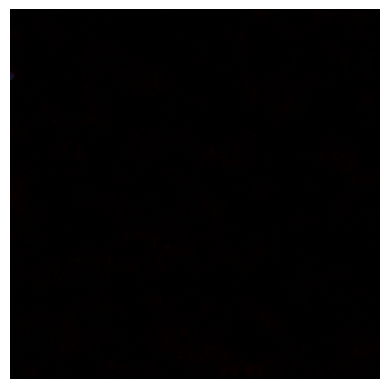

In [11]:
import matplotlib.pyplot as plt

# Function to visualize the generated image
def visualize_image(image_tensor):
    # Convert the tensor to an image format
    image = image_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Visualize the generated image
visualize_image(images)


In [6]:
##### Lets try on our eeg_data rather than on exapmle eeg data

import numpy as np
import torch
import matplotlib.pyplot as plt

# Load your EEG embeddings
eeg_embedding_file = "/kaggle/input/stable-diffusion-reconstruct/modified_eeg_embeddings.npy"
eeg_embeddings = np.load(eeg_embedding_file)  # Shape should be (num_embeddings, 512)

# Convert to a PyTorch tensor and send to the same device as the model
eeg_embeddings_tensor = torch.tensor(eeg_embeddings, dtype=torch.float32).to(device)

# Generate and visualize images for all EEG embeddings
for idx, eeg_embedding in enumerate(eeg_embeddings_tensor):
    print(f"Reconstructing Image {idx + 1}/{len(eeg_embeddings_tensor)}")
    noise = torch.randn(1, 4, 64, 64).to(device)  # Generate random noise
    eeg_embedding = eeg_embedding.unsqueeze(0).to(device)  # Add batch dimension
    images = reconstruct_image(eeg_embedding, noise, pipe)
    break

Reconstructing Image 1/16540
Noise latents size: torch.Size([1, 4, 64, 64])
Projected EEG for Cross-Attention Size: torch.Size([1, 1, 768])


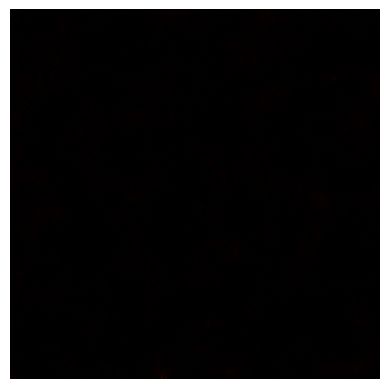

In [7]:
import matplotlib.pyplot as plt

# Function to visualize the generated image
def visualize_image(image_tensor):
    # Convert the tensor to an image format
    image = image_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Visualize the generated image
visualize_image(images)

In [8]:
### Preprocessing the image

from PIL import Image
import torchvision.transforms as T
import numpy as np

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),  # Resize to match Stable Diffusion input size
        T.ToTensor(),
        T.Normalize([0.5], [0.5])  # Normalize to [-1, 1] as required by the model
    ])
    return transform(image).unsqueeze(0).to(device)



# Function to add noise to the image
def add_noise_to_image(image_tensor, noise_level=0.1):
    noise = torch.randn_like(image_tensor) * noise_level
    return (image_tensor + noise).clamp(-1, 1)  # Ensure values are within [-1, 1]

# Example: Process and reconstruct images with noise
image_paths = ["/kaggle/input/stable-diffusion-reconstruct/osfstorage-archive/training_images/training_images/00001_aardvark/aardvark_01b.jpg"]  # Paths to corresponding images
noise_level = 0.1  # Adjust noise level


eeg_embedding_file = "/kaggle/input/stable-diffusion-reconstruct/modified_eeg_embeddings.npy"
eeg_embeddings = np.load(eeg_embedding_file)  # Shape should be (num_embeddings, 512)

# Convert to a PyTorch tensor and send to the same device as the model
eeg_embeddings_tensor = torch.tensor(eeg_embeddings, dtype=torch.float32).to(device)

# Function for image reconstruction
def reconstruct_image_final(eeg_embeddings, noise, pipe, num_inference_steps=200):
    device = next(pipe.unet.parameters()).device
    latents = pipe.vae.encode(noisy_image_tensor).latent_dist.sample()
    timesteps = torch.randint(0, num_inference_steps, (latents.size(0),)).to(device)
    
    
    ## OPtional part
    latent_noise = torch.randn_like(latents)  # [1, 4, 32, 32]
    noisy_latents = latents + latent_noise  # Optionally mix latent noise

    ###############################

    print(f"Noise latents size: {latents.size()}")  # Debugging
    reconstructed_latents = pipe.unet(latents, timesteps, eeg_embeddings)
    images = pipe.vae.decode(reconstructed_latents.sample).sample
    return images



for idx, (eeg_embedding, image_path) in enumerate(zip(eeg_embeddings_tensor, image_paths)):
    print(f"Processing Image {idx + 1}/{len(image_paths)}")

    # Load and preprocess the image
    image_tensor = load_and_preprocess_image(image_path)

    # Add noise to the image
    noisy_image_tensor = add_noise_to_image(image_tensor, noise_level)
    print(eeg_embedding.shape)

    # Pass the latents and EEG embedding to reconstruct the image
    eeg_embedding = eeg_embedding.unsqueeze(0).to(device)  # Add batch dimension
    images = reconstruct_image_final(eeg_embedding, image_tensor, pipe)
    break
    

Processing Image 1/1
torch.Size([512])
Noise latents size: torch.Size([1, 4, 32, 32])
Projected EEG for Cross-Attention Size: torch.Size([1, 1, 1024])


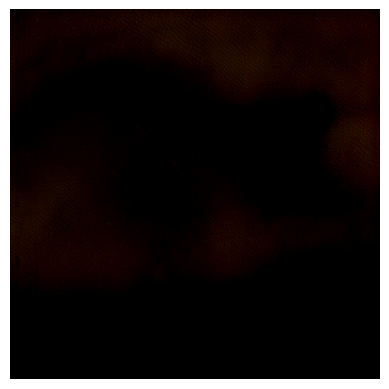

In [9]:
import matplotlib.pyplot as plt

# Function to visualize the generated image
def visualize_image(image_tensor):
    # Convert the tensor to an image format
    image = image_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Visualize the generated image
visualize_image(images)

In [16]:
!pip install realesrgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.8 MB/s eta 0:00:00:00:01
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=309cafbde1bebfe4c57990aa7eb898288255becdbc060e39a62c42918249dce6
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=1f75e6612ef24f3c8ddf127f1ab283b8e8fe4c5ed3e69b792cfd89ea102f669b
  Stored in directory

In [19]:
!pip install torchvision --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

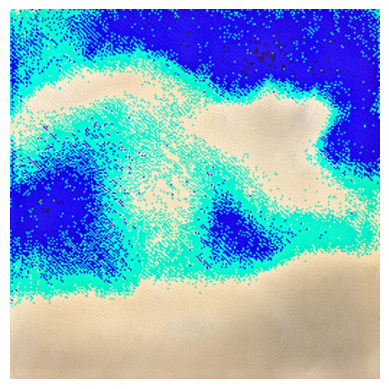

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'images' is a PyTorch tensor with shape (batch_size, channels, height, width)
# Convert the PyTorch tensor to a NumPy array
image_np = images.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Ensure the pixel values are in the range [0, 255] for OpenCV
image_np = (image_np * 255).astype(np.uint8)

# Upscale the image using OpenCV
upscaled_image = cv2.resize(image_np, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Visualize the upscaled image
plt.imshow(upscaled_image)
plt.axis("off")
plt.show()


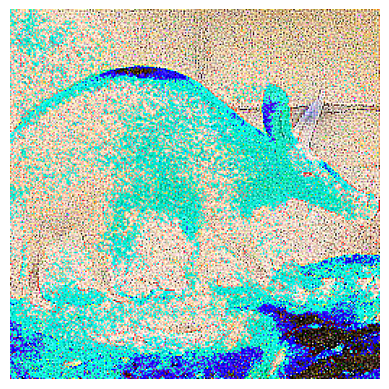

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply sharpening filter
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])

# Assuming 'image_np' is your upscaled image (NumPy array)
sharpened_image = cv2.filter2D(image_np, -1, sharpening_kernel)

# Visualize the sharpened image
plt.imshow(sharpened_image)
plt.axis("off")
plt.show()


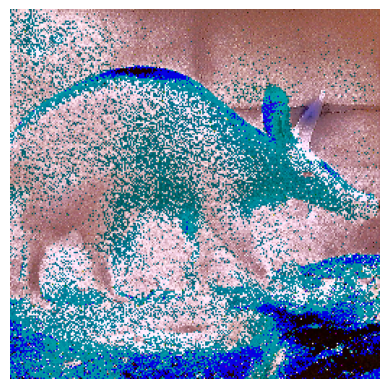

In [11]:
# Convert the image to YUV color space
image_yuv = cv2.cvtColor(image_np, cv2.COLOR_RGB2YUV)

# Increase the contrast by adjusting the Y channel (luminance)
image_yuv[..., 0] = cv2.equalizeHist(image_yuv[..., 0])

# Convert back to RGB
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


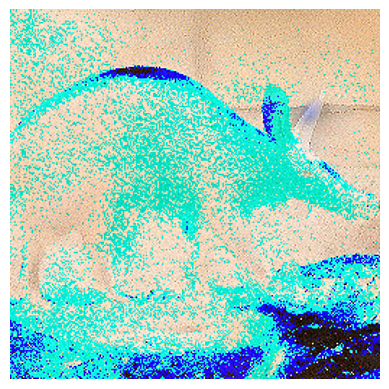

In [12]:
# Apply an edge enhancement filter (sharpening)
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
enhanced_image = cv2.filter2D(upscaled_image, -1, kernel)

# Display the sharpened image
plt.imshow(enhanced_image)
plt.axis("off")
plt.show()

In [16]:
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms as T
import torch
from PIL import Image

# Transform to convert PIL Image to tensor
image_transform = T.Compose([
    T.Resize((256, 256)),  # Resize both images to the same dimensions
    T.ToTensor()
])

# SSIM calculation function
def calculate_ssim(image1, image2, range_min=-1, range_max=1):
    image1 = image_transform(image1)
    image2 = image_transform(image2)

    image1_np = image1.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    image2_np = image2.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    
    # Set data_range based on normalization
    data_range = range_max - range_min

    # Calculate SSIM with a smaller window size and proper data range
    return ssim(image1_np, image2_np, win_size=3, channel_axis=2, data_range=data_range)

# Load original and generated images
sharpened_image = Image.open('/kaggle/input/test-1/Screenshot 2024-12-02 004919.png').convert("RGB")
original_image = Image.open('/kaggle/input/stable-diffusion-reconstruct/osfstorage-archive/training_images/training_images/00001_aardvark/aardvark_01b.jpg').convert("RGB")

# Calculate SSIM
ssim_value = calculate_ssim(original_image, sharpened_image, range_min=0, range_max=1)  # Adjust range_min and range_max based on normalization
print(f"SSIM between original and generated image: {ssim_value}")


SSIM between original and generated image: 0.22462892532348633


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Processing Image 1/1
Noise latents size: torch.Size([1, 4, 32, 32])
Projected EEG for Cross-Attention Size: torch.Size([1, 1, 1024])


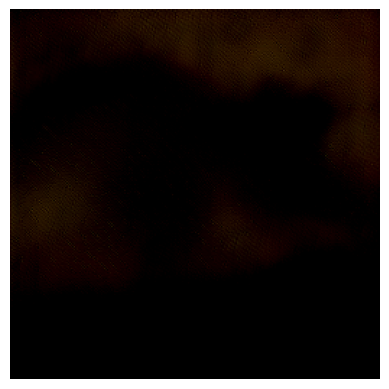

In [5]:
import torch
import torch.nn as nn
from diffusers import StableDiffusionPipeline  # Stable Diffusion v2.1 model
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# EEG Projection Layer
class EEGProjectionLayer(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EEGProjectionLayer, self).__init__()
        self.projection = nn.Linear(input_dim, latent_dim)

    def forward(self, eeg_embeddings):
        return self.projection(eeg_embeddings)

# EEG-enhanced Diffusion Model, using cross-attention for EEG embeddings
class EEGEnhancedDDIM_2(nn.Module):
    def __init__(self, ddim_model, eeg_projection_layer):
        super(EEGEnhancedDDIM_2, self).__init__()
        self.ddim_model = ddim_model
        self.eeg_projection_layer = eeg_projection_layer

    def forward(self, latents, timesteps, eeg_embeddings):
        device = next(self.ddim_model.parameters()).device
        latents = latents.to(device)
        timesteps = timesteps.to(device)

        # Project EEG embeddings for cross-attention (batch, 1, hidden_dim)
        eeg_projected = self.eeg_projection_layer(eeg_embeddings.to(device)).unsqueeze(1)
        print(f"Projected EEG for Cross-Attention Size: {eeg_projected.size()}")  # Debugging
        return self.ddim_model(latents, timesteps, encoder_hidden_states=eeg_projected)

# Load Pre-trained Stable Diffusion (Stable Diffusion 2.1)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to(device)  # Stable Diffusion 2.1

# Add EEG-enhanced DDIM
eeg_projection_layer = EEGProjectionLayer(input_dim=512, latent_dim=pipe.unet.config.cross_attention_dim).to(device)
pipe.unet = EEGEnhancedDDIM_2(pipe.unet, eeg_projection_layer).to(device)

### Preprocessing the image

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),  # Resize to match Stable Diffusion input size
        T.ToTensor(),
        T.Normalize([0.5], [0.5])  # Normalize to [-1, 1] as required by the model
    ])
    return transform(image).unsqueeze(0).to(device)

# Function to add noise to the image
def add_noise_to_image(image_tensor, noise_level=0.1):
    noise = torch.randn_like(image_tensor) * noise_level
    return (image_tensor + noise).clamp(-1, 1)  # Ensure values are within [-1, 1]

# Example: Process and reconstruct images with noise
image_paths = ["/kaggle/input/stable-diffusion-reconstruct/osfstorage-archive/training_images/training_images/00001_aardvark/aardvark_01b.jpg"]  # Paths to corresponding images
noise_level = 0.1  # Adjust noise level

eeg_embedding_file = "/kaggle/input/stable-diffusion-reconstruct/modified_eeg_embeddings.npy"
eeg_embeddings = np.load(eeg_embedding_file)  # Shape should be (num_embeddings, 512)

# Convert to a PyTorch tensor and send to the same device as the model
eeg_embeddings_tensor = torch.tensor(eeg_embeddings, dtype=torch.float32).to(device)

# Function for image reconstruction
def reconstruct_image_final(eeg_embeddings, noisy_image_tensor, pipe, num_inference_steps=200):
    device = next(pipe.unet.parameters()).device
    latents = pipe.vae.encode(noisy_image_tensor).latent_dist.sample()
    timesteps = torch.randint(0, num_inference_steps, (latents.size(0),)).to(device)
    
    ## Optional part
    latent_noise = torch.randn_like(latents)  # [1, 4, 32, 32]
    noisy_latents = latents + latent_noise  # Optionally mix latent noise

    print(f"Noise latents size: {latents.size()}")  # Debugging
    reconstructed_latents = pipe.unet(noisy_latents, timesteps, eeg_embeddings)
    images = pipe.vae.decode(reconstructed_latents.sample).sample
    return images

# Loop through EEG embeddings and images
for idx, (eeg_embedding, image_path) in enumerate(zip(eeg_embeddings_tensor, image_paths)):
    print(f"Processing Image {idx + 1}/{len(image_paths)}")

    # Load and preprocess the image
    image_tensor = load_and_preprocess_image(image_path)

    # Add noise to the image
    noisy_image_tensor = add_noise_to_image(image_tensor, noise_level)

    # Pass the latents and EEG embedding to reconstruct the image
    eeg_embedding = eeg_embedding.unsqueeze(0).to(device)  # Add batch dimension
    images = reconstruct_image_final(eeg_embedding, image_tensor, pipe)

    # Display the result
    plt.imshow(images.cpu().detach().numpy().transpose(0, 2, 3, 1)[0])
    plt.axis("off")
    plt.show()

    break  # Process only the first image for now


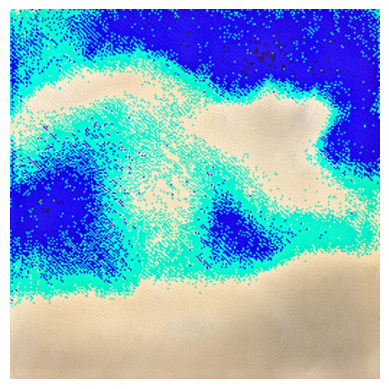

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'images' is a PyTorch tensor with shape (batch_size, channels, height, width)
# Convert the PyTorch tensor to a NumPy array
image_np = images.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Ensure the pixel values are in the range [0, 255] for OpenCV
image_np = (image_np * 255).astype(np.uint8)

# Upscale the image using OpenCV
upscaled_image = cv2.resize(image_np, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Visualize the upscaled image
plt.imshow(upscaled_image)
plt.axis("off")
plt.show()
